Description of dataset

We collected from IMDb, which is a popular online database and website that focuses on movies, television shows, and entertainment industry-related information. IMDb stands for the Internet Movie Database. The dataset includes information about 1000 movies. Here is an description of each attribute of the dataset.

    - Movie Index: A unique identifier or index number assigned to each movie in the dataset, representing the rank or position of each movie.

    - Title: The title of the movie, which represents its name.

    - Year: The year when the movie was released in theaters or made available to the public.

    - Certificate: The certificate or rating assigned to the movie by relevant film classification. Certificates include G (General Audience), PG (Parental Guidance), PG-13 (Parents Strongly Cautioned), R (Restricted), and more, depending on the country and its rating system.

    - Runtime: The duration of the movie in minutes, indicating how long the film runs.

    - Genre: The category to which the movie belongs, such as Action, Drama, Comedy, Science Fiction, etc. It describes the type and style of the movie.

    - Rating: The IMDb user rating, typically on a scale from 1 to 10, where users rate the movie based on their personal opinions and experiences.

    - Director: The name of the director(s) who directed the movie, responsible for overseeing the creative aspects of the film.

    - Star: The name(s) of the lead actor(s) or actress(es) who played significant roles in the movie, often the main characters.

    - Metascore: The Metascore is a numerical score assigned to a movie by aggregating critical reviews from professional critics. It provides a consolidated review score, typically on a scale from 1 to 100, representing the critical reception of the film.

    - Votes: The number of user votes that the movie has received on IMDb.

    - Gross (Million): The gross box office earnings of the movie in millions of dollars. This figure represents the total revenue generated by the movie during its theatrical run.

    - Top 250: This element shows top 250 movies out of 1000 movies.

# Web Scrawling to Database

In [ ]:
import sqlite3
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time
from selenium.common.exceptions import NoSuchElementException
import re

# Set up the Selenium WebDriver|
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

# Initial URL you want to scrape (page 1)
initial_url = 'https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&ref_=adv_prv'

# Initialize an empty list to store all movie details
all_movies = []

def scrape_page():
    # Find elements by CSS selector
    movie_elements = driver.find_elements(By.CSS_SELECTOR, '.lister-item')

    # Extract information from each movie element
    movies = []
    for movie_el in movie_elements:
        # Extract movie_index
        movie_index_elements = movie_el.find_elements(By.CSS_SELECTOR, '.lister-item-index')
        movie_index = movie_index_elements[0].text.strip('.').strip() if movie_index_elements else ""

        # Extract title
        title_elements = movie_el.find_elements(By.CSS_SELECTOR, '.lister-item-header a')
        title = title_elements[0].text if title_elements else ""

        # Extract year (numeric part only)
        year_elements = movie_el.find_elements(By.CSS_SELECTOR, '.lister-item-year')
        year_text = year_elements[0].text.strip('()').strip() if year_elements else ""
        year = re.search(r'\d{4}', year_text).group() if year_text else ""

        # Extract certificate
        certificate_elements = movie_el.find_elements(By.CSS_SELECTOR, '.certificate')
        certificate = certificate_elements[0].text if certificate_elements else ""

        # Extract runtime
        runtime_elements = movie_el.find_elements(By.CSS_SELECTOR, '.runtime')
        runtime = runtime_elements[0].text.replace("min", "") if runtime_elements else ""

        # Extract genre
        genre_elements = movie_el.find_elements(By.CSS_SELECTOR, '.genre')
        genre = genre_elements[0].text.strip() if genre_elements else ""

        # Extract rating
        rating_elements = movie_el.find_elements(By.CSS_SELECTOR, '.ratings-imdb-rating strong')
        rating = rating_elements[0].text if rating_elements else ""

        # Extract Director
        director_elements = movie_el.find_elements(By.XPATH, './/a[contains(@href, "/name/nm") and contains(@href, "adv_li_dr_0")]')
        director = director_elements[0].text if director_elements else ""

        # Extract Stars
        stars_elements = movie_el.find_elements(By.XPATH, './/a[contains(@href, "/name/nm") and contains(@href, "adv_li_st_")]')
        star = ', '.join([star.text for star in stars_elements])

        # Extract Meta Score:
        metascore_elements = movie_el.find_elements(By.CSS_SELECTOR, '.metascore')
        metascore = metascore_elements[0].text.strip() if metascore_elements else ""

        # Extract Votes:
        votes_element = movie_el.find_elements(By.XPATH, './/span[@class="text-muted" and contains(text(), "Votes:")]/following-sibling::span[@name="nv"]')
        votes =  votes_element[0].text.strip() if votes_element else ""

        # Extract Gross:

        gross_elements = movie_el.find_elements(By.XPATH, './/span[contains(text(), "Gross:")]/following-sibling::span[@name="nv"]')
        gross_in_million = gross_elements[0].text.strip().replace("M","") if gross_elements else ""

        if len(gross_elements) > 1:
            top250 = gross_elements[1].text.strip().replace ("#","")
        else:
            top250 = ""


        movies.append({
            "movie_index": movie_index,
            "title": title,
            "year": year,
            "certificate": certificate,
            "runtime": runtime,
            "genre": genre,
            "rating": rating,
            "director": director,
            "star": star,
            "metascore": metascore,
            "votes": votes,
            "gross_in_million": gross_in_million,
            "top250": top250
        })

    return movies


# Start scraping from the initial URL (page 1)
driver.get(initial_url)

# Wait for the page to load
time.sleep(5)

# Scrape details from the first page (page 1)
all_movies.extend(scrape_page())

# Initialize the SQLite database and cursor
conn = sqlite3.connect("movie_details.db")
cursor = conn.cursor()

# Create a table to store movie details if it doesn't exist
cursor.execute('''CREATE TABLE IF NOT EXISTS movie_details (
                  id INTEGER PRIMARY KEY AUTOINCREMENT,
                  movie_index TEXT,
                  title TEXT,
                  year varchar(50),
                  certificate TEXT,
                  runtime varchar(50),
                  genre TEXT,
                  rating varchar(50),
                  director TEXT,
                  star TEXT,
                  metascore varchar(50),
                  votes varchar(50),
                  gross_in_million varchar(50),
                  top250 varchar(50))''')


# Loop to navigate through all pages and scrape details
start_value = 0  # Initial value of start parameter
while True:
    # Check if there's a "Next" button
    try:
        next_button = driver.find_element(By.CSS_SELECTOR, '.lister-page-next.next-page')
    except NoSuchElementException:
        next_button = None

    # Scrape details from the current page (page 1 and subsequent pages)
    current_page_details = scrape_page()

    # Insert the details into the database
    for movie in current_page_details:
        cursor.execute(
        "INSERT INTO movie_details (movie_index, title, year, certificate, runtime, genre, rating, director,star, metascore, votes, gross_in_million, top250) VALUES (?,?,?,?,?,?,?,?, ?, ?, ?, ?, ?)",
        (movie["movie_index"], movie["title"], movie["year"], movie["certificate"], movie["runtime"], movie["genre"], movie["rating"], movie["director"], movie["star"], movie["metascore"], movie["votes"], movie["gross_in_million"], movie["top250"])
    )
    conn.commit()


    if next_button:
        # Increment start parameter for the next page
        start_value += 100

        # Build the URL for the next page with the updated start parameter
        next_page_url = initial_url + f'&start={start_value}'

        # Visit the next page
        driver.get(next_page_url)

        # Wait for the page to load
        time.sleep(5)
    else:
        # If there's no "Next" button, exit the loop
        break

# Close the database connection
conn.close()

# Close the browser
driver.quit()

# Data Retrieval, Preparation, and Data Cleaning and Transformation


In [ ]:
import sqlite3
import pandas as pd

#1: Connect to the SQLite database
conn = sqlite3.connect('movie_details.db')

#2: Execute an SQL query to retrieve data
cursor = conn.cursor()
cursor.execute('SELECT * FROM movie_details')

#3: Fetch the data into a Python list
data = cursor.fetchall()

column_names = ['ID', 'Movie Index', 'Title', 'Year', 'Certificate', 'Runtime', 'Genre', 'Rating', 'Director', 'Star', 'Metascore', 'Votes', 'Gross (Million)', 'Top 250']


#4: Create a Pandas DataFrame from the fetched data with custom column names
df = pd.DataFrame(data, columns=column_names)

#5: Close the database connection
conn.close()

column_names = ['ID', 'Movie Index', 'Title', 'Year', 'Certificate', 'Runtime', 'Genre', 'Rating', 'Director', 'Star', 'Metascore', 'Votes', 'Gross (Million)', 'Top 250']

#6: Drops the 'ID' column, which is considered unnecessary.

df.drop('ID',axis = 1, inplace=True)

df


,Movie Index,Title,Year,Certificate,Runtime,Genre,Rating,Director,Star,Metascore,Votes,Gross (Million),Top 250
0,1,The Shawshank Redemption,1994,R,142,Drama,9.3,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",82,"2,816,590",$28.34,1
1,2,The Godfather,1972,R,175,"Crime, Drama",9.2,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",100,"1,962,914",$134.97,2
2,3,The Dark Knight,2008,PG-13,152,"Action, Crime, Drama",9.0,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",84,"2,798,119",$534.86,3
3,4,Schindler's List,1993,R,195,"Biography, Drama, History",9.0,Steven Spielberg,"Liam Neeson, Ralph Fiennes, Ben Kingsley, Caro...",95,"1,415,827",$96.90,6
4,5,The Lord of the Rings: The Return of the King,2003,PG-13,201,"Action, Adventure, Drama",9.0,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...",94,"1,928,744",$377.85,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,996,When Marnie Was There,2014,PG,103,"Animation, Drama, Family",7.6,Hiromasa Yonebayashi,"Sara Takatsuki, Kasumi Arimura, Nanako Matsush...",72,"45,515",$0.77,
997,997,Control,2007,R,122,"Biography, Drama, Music",7.6,Anton Corbijn,"Sam Riley, Samantha Morton, Craig Parkinson, A...",78,"67,760",$0.87,
998,998,A Very Long Engagement,2004,R,133,"Drama, Mystery, Romance",7.6,Jean-Pierre Jeunet,"Audrey Tautou, Gaspard Ulliel, Jodie Foster, D...",76,"75,347",$6.17,
999,999,Shine,1996,PG-13,105,"Biography, Drama, Music",7.6,Scott Hicks,"Geoffrey Rush, Armin Mueller-Stahl, Justin Bra...",87,"55,971",$35.81,


In [ ]:
#7: Create a numerical dataset for performing descriptive statistic and regression analyses

numerical_columns =['Movie Index', 'Year', 'Runtime', 'Rating', 'Metascore', 'Votes', 'Gross (Million)', 'Top 250']
numerical_df = df[numerical_columns]

numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Movie Index      1001 non-null   object
 1   Year             1001 non-null   object
 2   Runtime          1001 non-null   object
 3   Rating           1001 non-null   object
 4   Metascore        1001 non-null   object
 5   Votes            1001 non-null   object
 6   Gross (Million)  1001 non-null   object
 7   Top 250          1001 non-null   object
dtypes: object(8)
memory usage: 62.7+ KB


# Data Cleaning

The data type for each column is object, so we have to clean dataset before performing our analyses.

 - Cleans the data by removing commas and replacing empty strings with NaN.
- Changes the data types of columns as needed (e.g., 'Movie Index' is changed to int, 'Rating' to float).
- Calculates the mean values for 'Metascore', 'Top 250', and 'Gross (Million)'.
- Performs descriptive statistics on the numerical dataset.

In [ ]:
import numpy as np

#Remove commas

numerical_df['Movie Index'] = numerical_df['Movie Index'].str.replace(',', '')
numerical_df['Votes'] = numerical_df['Votes'].str.replace(',', '')
numerical_df['Gross (Million)'] = numerical_df['Gross (Million)'].str.replace(',', '')
numerical_df['Gross (Million)'] = numerical_df['Gross (Million)'].str.replace('$', '')

## Replace empty strings with NaN
numerical_df['Metascore'].replace('', np.nan, inplace=True)
numerical_df['Top 250'].replace('', np.nan, inplace=True)
numerical_df['Gross (Million)'].replace('', np.nan, inplace=True)


#Check each unique value for each column

for column in numerical_df.columns:
    unique_values = numerical_df[column].unique()
    print(print(f"Unique values in '{column}': {unique_values}"))

Unique values in 'Movie Index': ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43' '44'
 '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57' '58'
 '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71' '72'
 '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84' '85' '86'
 '87' '88' '89' '90' '91' '92' '93' '94' '95' '96' '97' '98' '99' '100'
 '101' '102' '103' '104' '105' '106' '107' '108' '109' '110' '111' '112'
 '113' '114' '115' '116' '117' '118' '119' '120' '121' '122' '123' '124'
 '125' '126' '127' '128' '129' '130' '131' '132' '133' '134' '135' '136'
 '137' '138' '139' '140' '141' '142' '143' '144' '145' '146' '147' '148'
 '149' '150' '151' '152' '153' '154' '155' '156' '157' '158' '159' '160'
 '161' '162' '163' '164' '165' '166' '167' '168' '169' '170' '171' '172'
 '173' '174' '175' '176' '177' 

/var/folders/0g/n12bjh5j5rz4c440njxzw_sw0000gn/T/ipykernel_10069/2060328350.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_df['Movie Index'] = numerical_df['Movie Index'].str.replace(',', '')
/var/folders/0g/n12bjh5j5rz4c440njxzw_sw0000gn/T/ipykernel_10069/2060328350.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_df['Votes'] = numerical_df['Votes'].str.replace(',', '')
/var/folders/0g/n12bjh5j5rz4c440njxzw_sw0000gn/T/ipykernel_10069/2060328350.py:7: SettingWithCopyWarning: 
A v

In [ ]:
# Change the data type

numerical_df['Movie Index'] = numerical_df['Movie Index'].astype(int)
numerical_df['Year'] = numerical_df['Year'].astype(int)
numerical_df['Runtime'] = numerical_df['Runtime'].astype(int)
numerical_df['Rating'] = numerical_df['Rating'].astype(float)
numerical_df['Votes'] = numerical_df['Votes'].astype(int)
numerical_df['Metascore'] = numerical_df['Metascore'].fillna(0).astype(float)

# Calculate the mean
mean_metascore = numerical_df['Metascore'].mean()

numerical_df['Top 250'] = numerical_df['Top 250'].astype(float).fillna(0).astype(int)
mean_top_250 = numerical_df['Top 250'].mean()

numerical_df['Gross (Million)'] = numerical_df['Gross (Million)'].astype(float).fillna(0)
mean_gross_million = numerical_df['Gross (Million)'].mean()


/var/folders/0g/n12bjh5j5rz4c440njxzw_sw0000gn/T/ipykernel_10069/1260472311.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_df['Movie Index'] = numerical_df['Movie Index'].astype(int)
/var/folders/0g/n12bjh5j5rz4c440njxzw_sw0000gn/T/ipykernel_10069/1260472311.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_df['Year'] = numerical_df['Year'].astype(int)
/var/folders/0g/n12bjh5j5rz4c440njxzw_sw0000gn/T/ipykernel_10069/1260472311.py:5: SettingWithCopyWarning: 
A value is trying to be

In [ ]:
#Display information of a numerical dataframe with changed data types.
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Movie Index      1001 non-null   int64  
 1   Year             1001 non-null   int64  
 2   Runtime          1001 non-null   int64  
 3   Rating           1001 non-null   float64
 4   Metascore        1001 non-null   float64
 5   Votes            1001 non-null   int64  
 6   Gross (Million)  1001 non-null   float64
 7   Top 250          1001 non-null   int64  
dtypes: float64(3), int64(5)
memory usage: 62.7 KB


# Question 1: Will the run time, movie index, rating, metascore, votes affecting gross income?

#### - Perform descriptive statistics, data visualization charts and multivariate regression analysis for this question.

In [ ]:
#1: Perform descriptive analyses

numerical_df = numerical_df.dropna()

numerical_df.describe().round(0)

,Movie Index,Year,Runtime,Rating,Metascore,Votes,Gross (Million),Top 250
count,1001.0,1001.0,1001.0,1001.0,1001.0,1001.0,1001.0,1001.0
mean,500.0,1992.0,124.0,8.0,67.0,323969.0,56.0,27.0
std,289.0,24.0,29.0,0.0,31.0,393600.0,107.0,61.0
min,1.0,1920.0,45.0,8.0,0.0,25704.0,0.0,0.0
25%,250.0,1975.0,103.0,8.0,65.0,62048.0,0.0,0.0
50%,500.0,1999.0,120.0,8.0,77.0,159232.0,8.0,0.0
75%,750.0,2011.0,139.0,8.0,86.0,452278.0,58.0,0.0
max,1000.0,2023.0,321.0,9.0,100.0,2816590.0,937.0,250.0


    ==> This dataset has 1000 movie titles, starting from index 1.
    
    - The average number of votes is around 323,969, with a considerable standard deviation of approximately 393,600. This suggests that while the movie receives a substantial number of votes, there is significant variability in voting behavior among the movies.
    
    - The average year of release is around 1992, with a standard deviation of 24 years.
    
    - The average runtime of movies in the dataset is approximately 124 minutes, with a standard deviation of around 29 minutes. This suggests that there is a wide range of movie runtimes, with some movies being significantly longer or shorter than the average.
    
    - The average gross earnings (in million dollars) for movies in the dataset is approximately 56 million, with a significant standard deviation of approximately 107 million. This indicates substantial variability in the financial performance of movies, with some achieving very high earnings.

## Draw a correlation heatmap with gross income to see correlation relationship between gross income and other variables which are Runtime, Metascore, Votes, Year, Movie Index, Gross (Million).

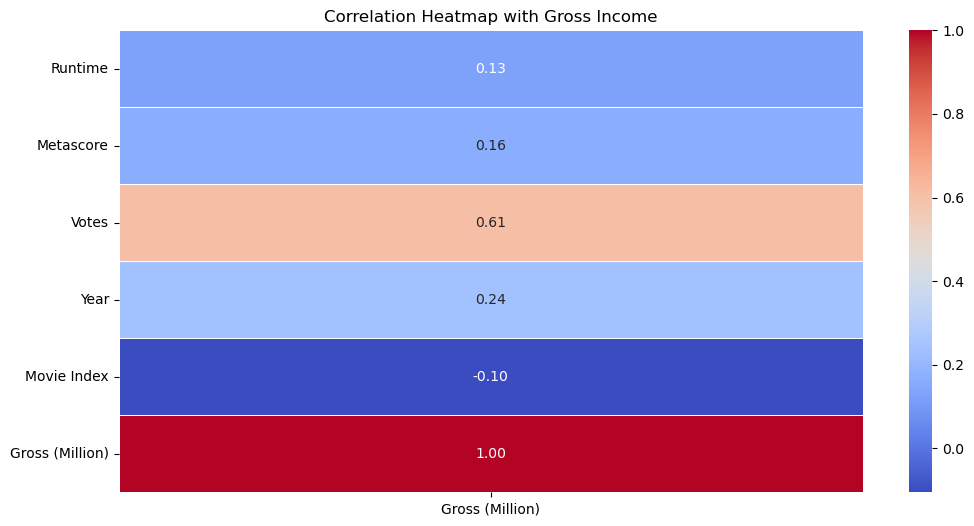

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


selected_columns = ['Runtime', 'Metascore', 'Votes', 'Year', 'Movie Index', 'Gross (Million)']

# Create a DataFrame containing only the selected columns
selected_df = numerical_df[selected_columns]

# Calculate the correlation matrix
correlation_matrix = selected_df.corr()

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix[['Gross (Million)']], annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap with Gross Income')
plt.show()

    => The correlation heatmap displays the votes attribute has the highest correlation with other variables, thus, plotting the scatterplot to see the correlation between gross income and number of votes.

## Create scatter plots to visualize the relationships between each of the independent variables (runtime, movie index, rating, metascore, votes) and the dependent variable (gross income).

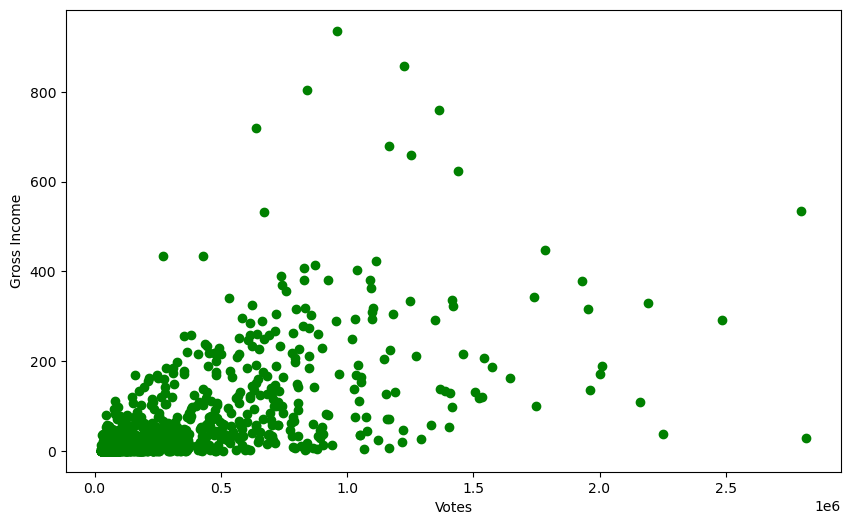

In [ ]:
import pandas as pd

import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt

# Assuming numerical_df is your DataFrame with the relevant columns

x = numerical_df[["Votes"]].to_numpy()

y = numerical_df[["Gross (Million)"]].to_numpy()

plt.figure (figsize = (10,6))

ax = plt.axes()

ax.set_xlabel('Votes')

ax.set_ylabel('Gross Income')

ax.scatter(x,y, color = "green")


=> The scatterplot shows there is a positive relationship between votes and gross income. When the number of votes increases, the amount of gross income also increases.

=> As correlation does not imply causation, it indicates that the 'votes' attribute is correlated with gross income, but it does not mean that changes in the number of votes cause changes in gross income."



##Perform first regression models to analyze relationship and make predictions between gross income and other variables which are Runtime, Metascore, Votes, Year, Movie Index, Gross (Million).

In [ ]:
import statsmodels.api as sm
X=numerical_df[['Runtime', 'Metascore', 'Votes', 'Year', 'Movie Index']].to_numpy()
Y=numerical_df[['Gross (Million)']].to_numpy()
X = sm.add_constant(X)
model = sm.OLS(Y,X)
# Create and fit the OLS regression model with robusst standard errors (HC3) for accurate coefficient results.
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     51.33
Date:                Sat, 16 Dec 2023   Prob (F-statistic):           2.08e-47
Time:                        13:24:59   Log-Likelihood:                -5842.0
No. Observations:                1001   AIC:                         1.170e+04
Df Residuals:                     995   BIC:                         1.173e+04
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -547.9392    203.683     -2.690      0.0

=> The first regression model shows that x2: Metascore has a p-value < 0.05; therefore, it is excluded from the model.

## Perform second regression model without including the metascore attribute. <strong>

In [ ]:
import statsmodels.api as sm
X=numerical_df[['Runtime', 'Votes', 'Year', 'Movie Index']].to_numpy()
Y=numerical_df[['Gross (Million)']].to_numpy()
X = sm.add_constant(X)
model = sm.OLS(Y,X)
# Create and fit the OLS regression model with robusst standard errors (HC3) for accurate coefficient results.
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     47.47
Date:                Sun, 26 Nov 2023   Prob (F-statistic):           1.46e-36
Time:                        21:37:05   Log-Likelihood:                -5842.1
No. Observations:                1001   AIC:                         1.169e+04
Df Residuals:                     996   BIC:                         1.172e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -530.1389    190.039     -2.790      0.0

=> The second regression model displays p-values of all variables < 0.05, indicating that there is a statistical relationship between gross income and other variables: runtime, votes, year, and movie index

## Perform a prediction based on the second regression model for gross income based on four variables: 'Runtime', 'Votes', 'Year', 'Movie Index'.

In [ ]:
const = -530.1389
value_of_Runtime = 120
value_of_Votes =  2900000
value_of_Year =2023
value_of_Movie_Index = 5

y = const + (0.2096 * value_of_Runtime) + (0.0002 * value_of_Votes) +

(0.2362 * value_of_Year) + (0.0641 * value_of_Movie_Index)

print(round(y))

553


    => Based on this regression model, a movie with a runtime of 120 minutes, 2,900,000 votes, an index of 5, and a release year of 2023 is predicted to have a gross income of $553 million.

# Question 2:  How can the insights from these three clustered groups, based on votes and ratings, help improve future movie productions?

### Perform Clustering Analyses

In [ ]:
df_subset = df [['Title', 'Director','Star']]

#1: Join columns of ('Title', 'Director','Star') with numerical dataset.

joined_df = numerical_df.join(df_subset)
joined_df

,Movie Index,Year,Runtime,Rating,Metascore,Votes,Gross (Million),Top 250,Title,Director,Star
0,1,1994,142,9.3,82.0,2816590,28.34,1,The Shawshank Redemption,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi..."
1,2,1972,175,9.2,100.0,1962914,134.97,2,The Godfather,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke..."
2,3,2008,152,9.0,84.0,2798119,534.86,3,The Dark Knight,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M..."
3,4,1993,195,9.0,95.0,1415827,96.90,6,Schindler's List,Steven Spielberg,"Liam Neeson, Ralph Fiennes, Ben Kingsley, Caro..."
4,5,2003,201,9.0,94.0,1928744,377.85,7,The Lord of the Rings: The Return of the King,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or..."
...,...,...,...,...,...,...,...,...,...,...,...
996,996,2014,103,7.6,72.0,45515,0.77,0,When Marnie Was There,Hiromasa Yonebayashi,"Sara Takatsuki, Kasumi Arimura, Nanako Matsush..."
997,997,2007,122,7.6,78.0,67760,0.87,0,Control,Anton Corbijn,"Sam Riley, Samantha Morton, Craig Parkinson, A..."
998,998,2004,133,7.6,76.0,75347,6.17,0,A Very Long Engagement,Jean-Pierre Jeunet,"Audrey Tautou, Gaspard Ulliel, Jodie Foster, D..."
999,999,1996,105,7.6,87.0,55971,35.81,0,Shine,Scott Hicks,"Geoffrey Rush, Armin Mueller-Stahl, Justin Bra..."


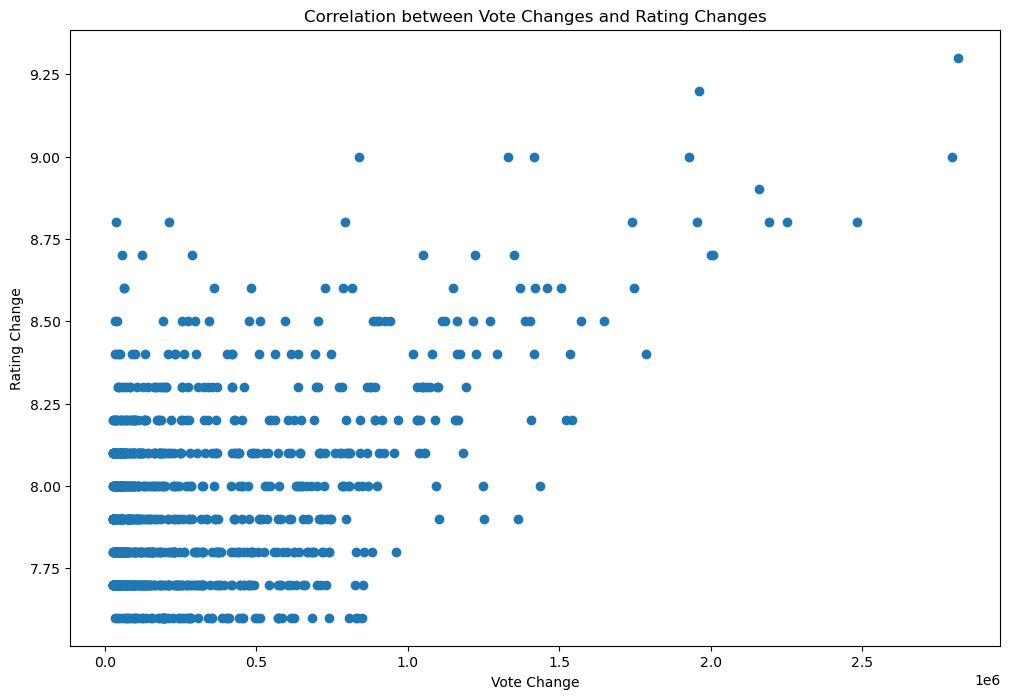

In [ ]:
#2: Draw a scatterplot between vote and rating changes
plt.figure(figsize=(12, 8))
plt.scatter(joined_df['Votes'], joined_df['Rating'])
plt.title('Correlation between Vote Changes and Rating Changes')
plt.xlabel('Vote Change')
plt.ylabel('Rating Change')
plt.show()

In [ ]:
#3: #Perform K-means Elbow Curve visualization

/Users/ramivy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ramivy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ramivy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ramivy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

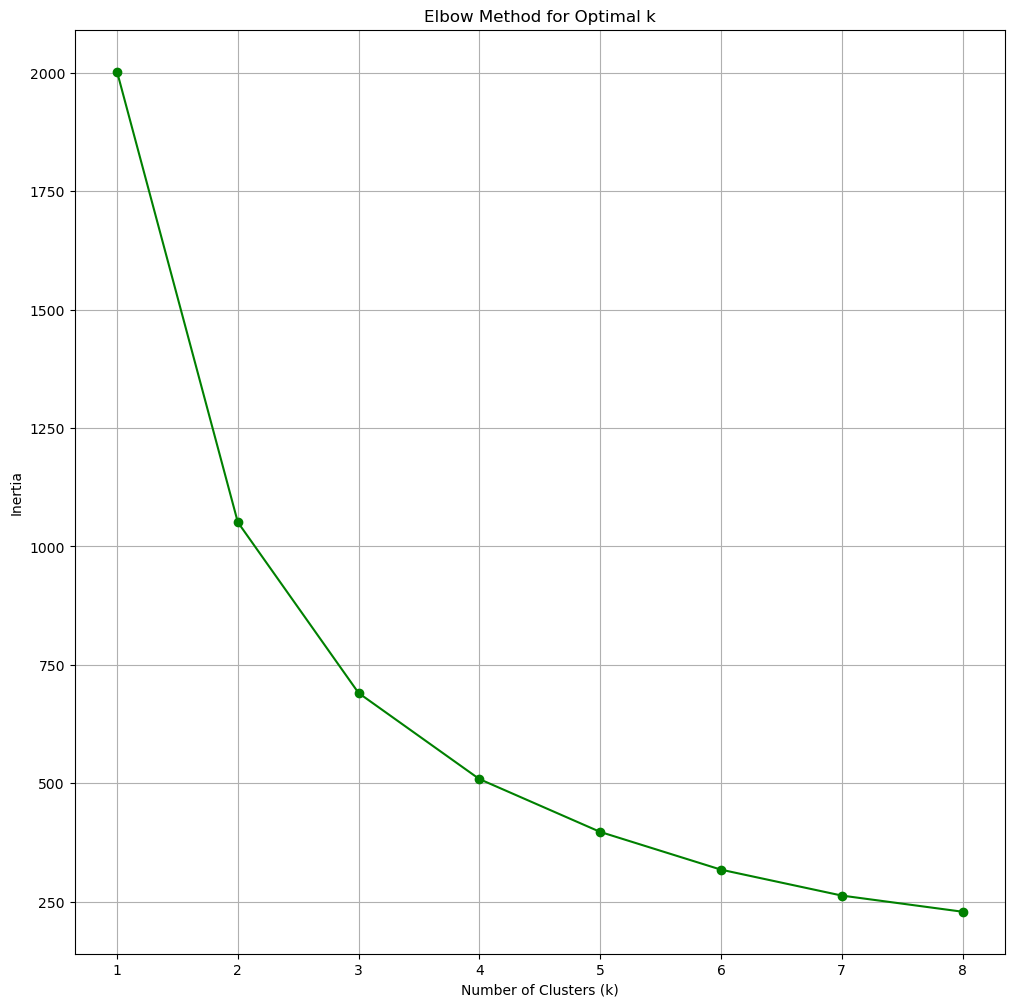

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select two columns for visualization
x_feature = 'Votes'
y_feature = 'Rating'

# Create a DataFrame containing only the selected columns
data_for_clustering = joined_df[[x_feature, y_feature]]

# Standardize the data (scaling)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# Initialize an empty list to store the inertia values (within-cluster sum of squares)
inertia_values = []

# Specify a range of k values (number of clusters) to perform the elbow method.
k_values = range(1, 9)

# Iterate through different values of k and compute inertia for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_data)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(12, 12))
plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='g')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


    --> From the elbow visualization, k = 3 is an optimal cluster. Even k = 2 is an elbow point but choosing 2 groups are too few.

In [ ]:
#4: #Perform K-means with k = 3

/Users/ramivy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


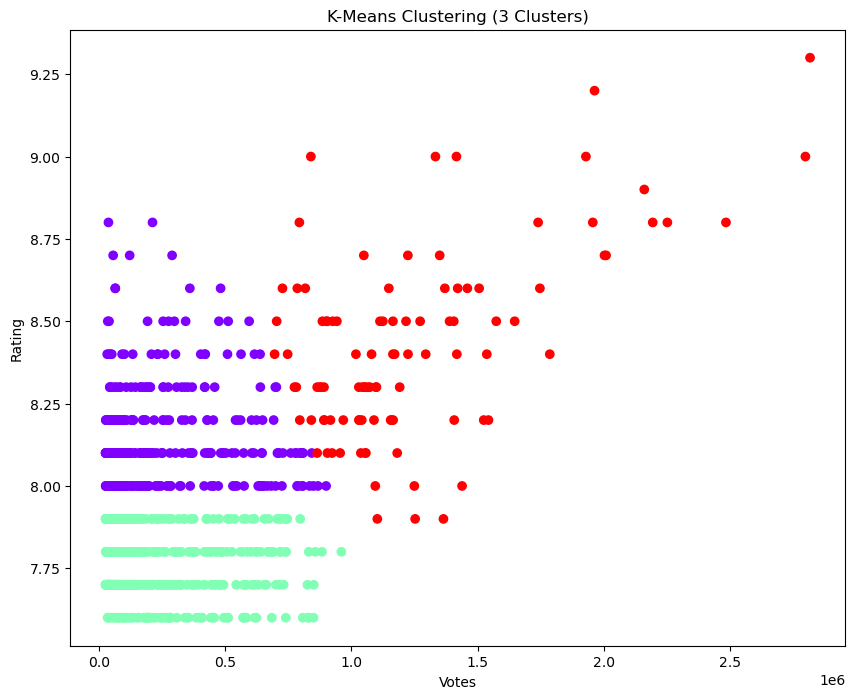

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select two columns for visualization
x_feature = 'Votes'
y_feature = 'Rating'

# Specify the number of clusters (k)
k = 3

# Create a DataFrame containing only the selected columns
data_for_clustering = joined_df[[x_feature, y_feature]]

# Standardize the data (scaling)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# Perform k-means clustering with 3 clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(scaled_data)

# Add cluster labels to the original DataFrame
joined_df['Cluster'] = kmeans.labels_

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(joined_df[x_feature], joined_df[y_feature], c=joined_df['Cluster'], cmap='rainbow')
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title('K-Means Clustering (3 Clusters)')

# Show the plot
plt.show()


- Interpretation

    - The green cluster has the lowest range of votes, with ratings ranging from around 7.6 to 7.8.These movies are either less popular, less favored, or perhaps newer and not yet widely reviewed.
    
    - The purple cluster is at the lower end of the vote scale and has ratings clustered between 8.0 and 8.8.This could suggest that these items are less frequently reviewed, yet those who do review them rate them favorably.
    
    - The red cluster is in the middle range of votes, with ratings mostly between 8.0 and 9.25.This cluster could indicate movies that are generally well-regarded and somewhat popular.
        
    ==> The presence of three clustered groups is beneficial for film studios and producers for movie quality control. For instance, they can use these insights to analyze the films in the red and purple groups to understand what aspects are appealing to audiences and apply these learnings to future productions.


In [ ]:
# Print cluster 0
green_cluster = joined_df[joined_df['Cluster'] == 0]

green_cluster.head(10)

,Movie Index,Year,Runtime,Rating,Metascore,Votes,Gross (Million),Top 250,Title,Director,Star,Cluster
14,15,2021,164,8.8,0.0,211898,0.00,0,Jai Bhim,T.J. Gnanavel,"Suriya, Lijo Mol Jose, Manikandan K., Rajisha ...",0
15,16,2022,164,8.8,0.0,37349,0.00,0,777 Charlie,Kiranraj K,"Rakshit Shetty, Charlie, Sangeetha Sringeri, R...",0
16,17,2023,140,8.7,86.0,289511,0.00,0,Spider-Man: Across the Spider-Verse,Joaquim Dos Santos,"Shameik Moore, Hailee Steinfeld, Brian Tyree H...",0
22,23,2020,153,8.7,0.0,121498,0.00,0,Soorarai Pottru,Sudha Kongara,"Suriya, Paresh Rawal, Urvashi, Aparna Balamurali",0
23,24,2022,157,8.7,0.0,55949,0.00,0,Rocketry: The Nambi Effect,Madhavan,"Madhavan, Simran, Rajit Kapoor, Ravi Raghavendra",0
33,34,1946,130,8.6,89.0,481636,0.00,0,It's a Wonderful Life,Frank Capra,"James Stewart, Donna Reed, Lionel Barrymore, T...",0
34,35,1954,207,8.6,98.0,359822,0.27,21,Seven Samurai,Akira Kurosawa,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",0
35,36,1962,133,8.6,85.0,64785,0.00,0,Harakiri,Masaki Kobayashi,"Tatsuya Nakadai, Akira Ishihama, Shima Iwashit...",0
36,37,2022,163,8.6,0.0,63954,0.00,0,Sita Ramam,Hanu Raghavapudi,"Dulquer Salmaan, Mrunal Thakur, Rashmika Manda...",0
37,38,2023,180,8.5,88.0,474970,0.00,0,Oppenheimer,Christopher Nolan,"Cillian Murphy, Emily Blunt, Matt Damon, Rober...",0


In [ ]:
#Print cluster 1

purple_cluster = joined_df[joined_df['Cluster'] == 1]

purple_cluster.head(10)

,Movie Index,Year,Runtime,Rating,Metascore,Votes,Gross (Million),Top 250,Title,Director,Star,Cluster
471,471,1993,76,7.9,82.0,364590,75.08,0,The Nightmare Before Christmas,Henry Selick,"Danny Elfman, Chris Sarandon, Catherine O'Hara...",1
472,472,2023,150,7.9,64.0,339048,0.00,0,Guardians of the Galaxy Vol. 3,James Gunn,"Chris Pratt, Chukwudi Iwuji, Bradley Cooper, P...",1
474,474,1990,105,7.9,74.0,513342,56.36,0,Edward Scissorhands,Tim Burton,"Johnny Depp, Winona Ryder, Dianne Wiest, Antho...",1
475,475,2004,99,7.9,76.0,582512,13.54,0,Shaun of the Dead,Edgar Wright,"Simon Pegg, Nick Frost, Kate Ashfield, Lucy Davis",1
476,476,2019,130,7.9,82.0,745892,165.36,0,Knives Out,Rian Johnson,"Daniel Craig, Chris Evans, Ana de Armas, Jamie...",1
477,477,1982,115,7.9,92.0,428809,435.11,0,E.T. the Extra-Terrestrial,Steven Spielberg,"Henry Thomas, Drew Barrymore, Peter Coyote, De...",1
478,478,2004,142,7.9,82.0,671559,249.36,0,Harry Potter and the Prisoner of Azkaban,Alfonso Cuarón,"Daniel Radcliffe, Emma Watson, Rupert Grint, R...",1
479,479,2001,147,7.9,86.0,375112,7.22,0,Mulholland Drive,David Lynch,"Naomi Watts, Laura Harring, Justin Theroux, Je...",1
480,480,2000,122,7.9,90.0,288402,32.53,0,Almost Famous,Cameron Crowe,"Billy Crudup, Patrick Fugit, Kate Hudson, Fran...",1
481,481,2016,116,7.9,81.0,742528,100.55,0,Arrival,Denis Villeneuve,"Amy Adams, Jeremy Renner, Forest Whitaker, Mic...",1


In [ ]:
##Print cluster 2

red_cluster = joined_df[joined_df['Cluster'] == 2]

red_cluster

,Movie Index,Year,Runtime,Rating,Metascore,Votes,Gross (Million),Top 250,Title,Director,Star,Cluster
0,1,1994,142,9.3,82.0,2816590,28.34,1,The Shawshank Redemption,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",2
1,2,1972,175,9.2,100.0,1962914,134.97,2,The Godfather,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",2
2,3,2008,152,9.0,84.0,2798119,534.86,3,The Dark Knight,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",2
3,4,1993,195,9.0,95.0,1415827,96.90,6,Schindler's List,Steven Spielberg,"Liam Neeson, Ralph Fiennes, Ben Kingsley, Caro...",2
4,5,2003,201,9.0,94.0,1928744,377.85,7,The Lord of the Rings: The Return of the King,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...",2
...,...,...,...,...,...,...,...,...,...,...,...,...
358,358,2014,121,8.0,76.0,1249102,333.18,0,Guardians of the Galaxy,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2
361,361,2012,143,8.0,69.0,1438133,623.28,0,The Avengers,Joss Whedon,"Robert Downey Jr., Chris Evans, Scarlett Johan...",2
473,473,1997,194,7.9,75.0,1252274,659.33,0,Titanic,James Cameron,"Leonardo DiCaprio, Kate Winslet, Billy Zane, K...",2
484,484,2008,126,7.9,79.0,1102491,318.41,0,Iron Man,Jon Favreau,"Robert Downey Jr., Gwyneth Paltrow, Terrence H...",2


# Question 3: What are the predominant themes or recurring elements in the movie titles?

- Perform Part of Speech Tagging

In [ ]:
# 1. Convert the 'Title' column to a list of strings
Title = joined_df['Title'].tolist()

# 2. Tokenize the words in the 'Title' variable
tokenized_words = []
for title in Title:
    words = nltk.word_tokenize(title)
    tokenized_words += words

# 3. Compute the frequency distribution
freq_dist = FreqDist(tokenized_words)

# 4. Print the most common 30 words
print(freq_dist.most_common(50))

[('The', 248), ('of', 112), ('the', 109), (':', 62), ('and', 35), ("'s", 26), ('A', 22), ('a', 22), (',', 20), ('in', 20), ('Man', 19), ('.', 17), ('2', 15), ('to', 15), ('My', 15), ('on', 12), ('Story', 11), ('Star', 10), ('Day', 9), ('-', 8), ('Life', 8), ('Once', 8), ('Time', 8), ('for', 8), ('All', 8), ('In', 8), ('King', 7), ('Last', 7), ('Girl', 7), ('Black', 7), ('Harry', 7), ('One', 6), ('Wars', 6), ('Is', 6), ('by', 6), ('with', 6), ('Big', 6), ('Dead', 6), ('Baby', 6), ('Red', 6), ('Who', 6), ('Night', 6), ('Dark', 5), ('Part', 5), ('Men', 5), ('Good', 5), ('Episode', 5), ('It', 5), ('Upon', 5), ('Your', 5)]


In [ ]:
tagged_words = nltk.pos_tag(tokenized_words)

# 6. Define a list of stopwords and add custom stopwords
stop_words = set(stopwords.words('english'))
custom_stopwords = set(["ho", "la", "great", "drishyam", 'vol.', ':', 'ii'])

# 7. Create an empty list to store nouns
noun = []

# 8. Search for proper nouns and stopwords
for w, pos in tagged_words:
    if pos == 'NNP' and w.lower() not in stop_words:
        noun.append(w.lower())  # Convert to lowercase and add to the noun list

# 9. Create a frequency distribution of nouns
noun_freq_dist = FreqDist(noun)

# 10. Display the most common nouns
print(noun_freq_dist.most_common(30))

[('man', 17), ('story', 11), ('star', 10), ('day', 9), ('life', 8), ('time', 8), ('girl', 7), ('black', 7), ('harry', 7), ('king', 6), ('wars', 6), ('big', 6), ('baby', 6), ('red', 6), ('night', 6), ('dark', 5), ('men', 5), ('episode', 5), ('blood', 5), ('wind', 5), ('potter', 5), ('dead', 5), ('wild', 5), ('dragon', 5), ('la', 5), ('winter', 5), ('ii', 4), ('good', 4), ('green', 4), ('city', 4)]


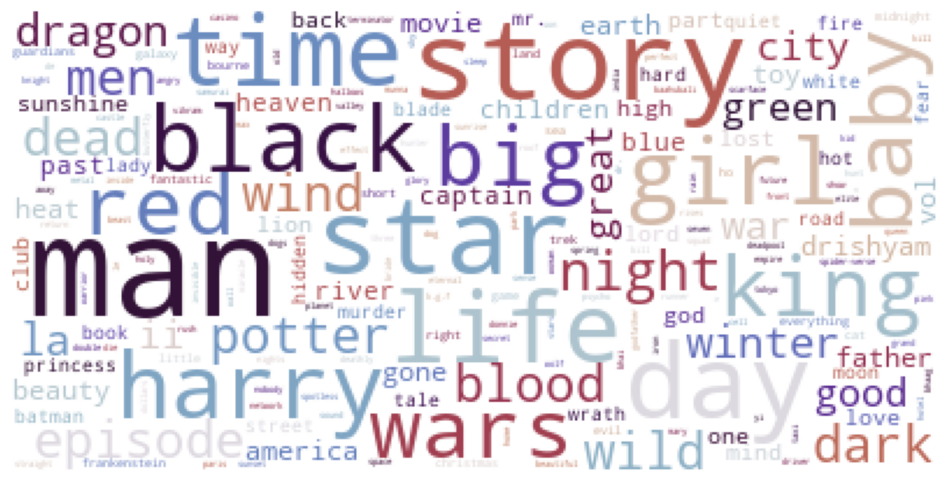

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#11: Generate a word cloud image for 30 popular nouns
wc = WordCloud(background_color='white', max_font_size= 60, colormap="twilight")
wc.generate_from_frequencies(noun_freq_dist)

#12: Plot the word cloud for 30 popular nouns
plt.figure(figsize=(12,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

12. Intepretation:

- This Wordcloud shows the popular themes among 1000 movies, which can be used for identifying a popular keywords in a movie title.

    - Man is the most frequent word, suggesting a focus in a male character.
    
    - Day, Time and Life are also common, indicating an emphasis on time and existential elements.
    
    - Night, Story, King, Girl", "Baby", "Dark" and "Dead" suggest recurring narrative elements, such as royalty, gender roles, and finality or mortality.
        
    - "Black" is also a popular color in a movie title.